# Estimating Multivariate Models with brms
### This example is directly adapted from: [HERE](https://cran.r-project.org/web/packages/brms/vignettes/brms_multivariate.html)

In [1]:

import os
import sys

try:
    repo_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
    if repo_root not in sys.path:
        sys.path.insert(0, repo_root)
except:
    pass

from brmspy import brms

from brmspy import bf, set_rescor, lf
import pandas as pd
import arviz as az
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("darkgrid")
brms.install_rpackage("MCMCglmm")
#brms.install_prebuilt()

R callback write-console: Error in loadNamespace(x) : there is no package called ‘cmdstanr’
  
R callback write-console: CmdStan path set to: /Users/sebastian/.brmspy/runtime/macos-arm64-r4.5-0.1.0/cmdstan
  
[brmspy] MCMCglmm 2.36 already installed.


In [2]:
from brmspy.runtime import _rtools
_rtools._discover_rtools_installer("45")

'https://cran.r-project.org/bin/windows/Rtools/rtools45/files/rtools45-6691-6492.exe'

## Introduction

In the present example, we want to discuss how to specify multivariate multilevel models using brms. We call a model multivariate if it contains multiple response variables, each being predicted by its own set of predictors. Consider an example from biology. Hadfield, Nutall, Osorio, and Owens (2007) analyzed data of the Eurasian blue tit (https://en.wikipedia.org/wiki/Eurasian_blue_tit). They predicted the tarsus length as well as the back color of chicks. Half of the brood were put into another fosternest, while the other half stayed in the fosternest of their own dam. This allows to separate genetic from environmental factors. Additionally, we have information about the hatchdate and sex of the chicks (the latter being known for 94% of the animals).

In [35]:
df = brms.get_data("BTdata", package = "MCMCglmm")
df.head()

,tarsus,back,animal,dam,fosternest,hatchdate,sex
1,-1.892297,1.146421,207,56,74,-0.687402,1
2,1.136110,-0.759652,219,57,72,-0.687402,2
3,0.984689,0.144937,395,61,16,-0.427981,2
4,0.379008,0.255585,46,38,4,-1.465664,2
5,-0.075253,-0.300699,38,43,12,-1.465664,1


# Basic Multivariate Models

We begin with a relatively simple multivariate normal model.

In [36]:
bform1 = bf("""
mvbind(tarsus, back) ~
    sex + 
    hatchdate + 
    (1|p|fosternest) + 
    (1|q|dam)
""") + set_rescor(rescor=True)

fit1 = brms.brm(bform1, data = df, chains = 2, cores = 2, silent = 2, refresh = 0)

[brmspy] Fitting model with brms (backend: cmdstanr)...


As can be seen in the model code, we have used mvbind notation to tell brms that both tarsus and back are separate response variables. The term (1|p|fosternest) indicates a varying intercept over fosternest. By writing |p| in between we indicate that all varying effects of fosternest should be modeled as correlated. This makes sense since we actually have two model parts, one for tarsus and one for back. The indicator p is arbitrary and can be replaced by other symbols that comes into your mind (for details about the multilevel syntax of brms, see help("brmsformula") and vignette("brms_multilevel")). Similarly, the term (1|q|dam) indicates correlated varying effects of the genetic mother of the chicks. Alternatively, we could have also modeled the genetic similarities through pedigrees and corresponding relatedness matrices, but this is not the focus of this vignette (please see vignette("brms_phylogenetics")). The model results are readily summarized via



In [37]:
#fit1 = brms.add_criterion(fit1, "loo")
brms.summary(fit1)

[brmspy][iterate_robject_to_dataclass][WARNING] Type of param 'group' <class 'list'> does not match expected '<class 'str'>'


Summary of brmsfit (Python)

Formula: NULL
   Data: structure(list(tarsus = c(-1.89229718155107, 1.136 (Number of observations: 828)
  Draws: 2 chains, each with iter = 2000; warmup = 1000; thin = 1;
         total post-warmup draws = 2000

Group-Level Effects:
  Groups: dam (106), fosternest (104)
 ~dam
                                        Estimate  Est.Error  l-95% CI  u-95% CI      Rhat    Bulk_ESS     Tail_ESS
  sd(tarsus_Intercept)                  0.467151   0.051386  0.373728  0.574337  0.999788  664.918580  1102.529351
  sd(back_Intercept)                    0.253870   0.075402  0.102113  0.395166  1.007419  269.919307   574.306197
  cor(tarsus_Intercept,back_Intercept) -0.505498   0.234557 -0.942131 -0.036365  1.001446  370.653717   401.585777
 ~fosternest
                                        Estimate  Est.Error  l-95% CI  u-95% CI      Rhat    Bulk_ESS    Tail_ESS
  sd(tarsus_Intercept)                  0.306356   0.053846  0.201563  0.408417  1.003985  592.944997  970.

The summary output of multivariate models closely resembles those of univariate models, except that the parameters now have the corresponding response variable as prefix. Across dams, tarsus length and back color seem to be negatively correlated, while across fosternests the opposite is true. This indicates differential effects of genetic and environmental factors on these two characteristics. Further, the small residual correlation rescor(tarsus, back) on the bottom of the output indicates that there is little unmodeled dependency between tarsus length and back color. Although not necessary at this point, we have already computed and stored the LOO information criterion of fit1, which we will use for model comparisons. Next, let’s take a look at some posterior-predictive checks, which give us a first impression of the model fit.

<Axes: xlabel='tarsus'>

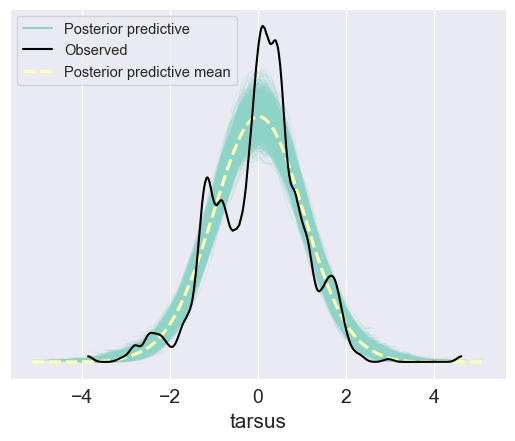

In [38]:
az.plot_ppc(fit1.idata, var_names=['tarsus'])

<Axes: xlabel='back'>

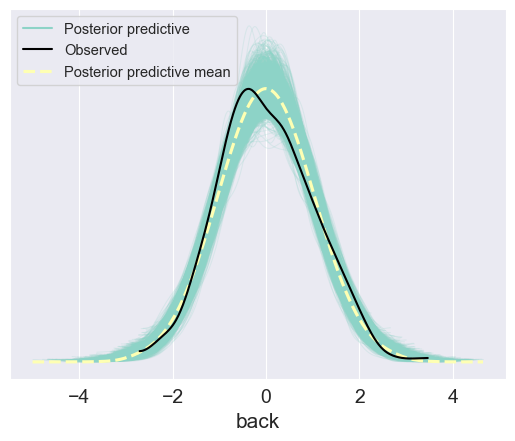

In [39]:
az.plot_ppc(fit1.idata, var_names=["back"])

This looks pretty solid, but we notice a slight unmodeled left skewness in the distribution of tarsus. We will come back to this later on. Next, we want to investigate how much variation in the response variables can be explained by our model and we use a Bayesian generalization of the 𝑅2
 coefficient.

In [40]:
brms.call("bayes_R2", fit1)

,Estimate,Est.Error,Q2.5,Q97.5
R2tarsus,0.379106,0.025379,0.326334,0.427394
R2back,0.197111,0.027749,0.142882,0.250863


Clearly, there is much variation in both animal characteristics that we can not explain, but apparently we can explain more of the variation in tarsus length than in back color.

## More Complex Multivariate Models

Now, suppose we only want to control for sex in tarsus but not in back and vice versa for hatchdate. Not that this is particular reasonable for the present example, but it allows us to illustrate how to specify different formulas for different response variables. We can no longer use mvbind syntax and so we have to use a more verbose approach:

In [41]:
bf_tarsus = bf("tarsus ~ sex + (1|p|fosternest) + (1|q|dam)")
bf_back = bf("back ~ hatchdate + (1|p|fosternest) + (1|q|dam)")

fit2 = brms.brm(bf_tarsus + bf_back + set_rescor(True), data = df, chains = 2, cores = 2, silent = 2, refresh = 0)

[brmspy] Fitting model with brms (backend: cmdstanr)...


Note that we have literally added the two model parts via the + operator, which is in this case equivalent to writing mvbf(bf_tarsus, bf_back). See help("brmsformula") and help("mvbrmsformula") for more details about this syntax. Again, we summarize the model first.

In [42]:
#fit2 = brms.add_criterion(fit2, "loo")
brms.summary(fit2)

[brmspy][iterate_robject_to_dataclass][WARNING] Type of param 'group' <class 'list'> does not match expected '<class 'str'>'


Summary of brmsfit (Python)

Formula: NULL
   Data: structure(list(tarsus = c(-1.89229718155107, 1.136 (Number of observations: 828)
  Draws: 2 chains, each with iter = 2000; warmup = 1000; thin = 1;
         total post-warmup draws = 2000

Group-Level Effects:
  Groups: dam (106), fosternest (104)
 ~dam
                                        Estimate  Est.Error  l-95% CI  u-95% CI      Rhat    Bulk_ESS     Tail_ESS
  sd(tarsus_Intercept)                  0.472603   0.050787  0.379136  0.580197  1.002675  732.548521  1311.654637
  sd(back_Intercept)                    0.251381   0.071649  0.107120  0.393473  0.999821  380.386267   573.877254
  cor(tarsus_Intercept,back_Intercept) -0.529769   0.223199 -0.959142 -0.085407  1.002527  487.521206   596.761410
 ~fosternest
                                        Estimate  Est.Error  l-95% CI  u-95% CI      Rhat    Bulk_ESS     Tail_ESS
  sd(tarsus_Intercept)                  0.306708   0.055699  0.200823  0.415624  0.999387  730.586303  122

Let’s find out, how model fit changed due to excluding certain effects from the initial model:

In [48]:
brms.loo_compare(fit1, fit2)

: 

Apparently, there is no noteworthy difference in the model fit. Accordingly, we do not really need to model sex and hatchdate for both response variables, but there is also no harm in including them (so I would probably just include them).

To give you a glimpse of the capabilities of brms’ multivariate syntax, we change our model in various directions at the same time. Remember the slight left skewness of tarsus, which we will now model by using the skew_normal family instead of the gaussian family. Since we do not have a multivariate normal (or student-t) model, anymore, estimating residual correlations is no longer possible. We make this explicit using the set_rescor function. Further, we investigate if the relationship of back and hatchdate is really linear as previously assumed by fitting a non-linear spline of hatchdate. On top of it, we model separate residual variances of tarsus for male and female chicks.



In [44]:
from brmspy.brms_functions.families import skew_normal, gaussian

In [45]:

bf_tarsus = bf("tarsus ~ sex + (1|p|fosternest) + (1|q|dam)") + lf("sigma ~ 0 + sex") + skew_normal()
bf_back = bf("back ~ s(hatchdate) + (1|p|fosternest) + (1|q|dam)") + gaussian()

fit3 = brms.brm(
  bf_tarsus + bf_back + set_rescor(False),
  data = df, chains = 2, cores = 2,
  control = {"adapt_delta": 0.95},
  silent = 2, refresh = 0
)

[brmspy] Fitting model with brms (backend: cmdstanr)...
R callback write-console: Warning: 4 of 2000 (0.0%) transitions ended with a divergence.
See https://mc-stan.org/misc/warnings for details.

  


Again, we summarize the model and look at some posterior-predictive checks.

In [46]:
#fit3 = brms.add_criterion(fit3, "loo")
brms.summary(fit3)

R callback write-console: In addition:   
R callback write-console: Warning message:
  
R callback write-console: There were 4 divergent transitions after warmup. Increasing adapt_delta above 0.95 may help. See http://mc-stan.org/misc/warnings.html#divergent-transitions-after-warmup 
  
[brmspy][iterate_robject_to_dataclass][WARNING] Type of param 'group' <class 'list'> does not match expected '<class 'str'>'


Summary of brmsfit (Python)

Formula: NULL
   Data: structure(list(tarsus = c(-1.89229718155107, 1.136 (Number of observations: 828)
  Draws: 2 chains, each with iter = 2000; warmup = 1000; thin = 1;
         total post-warmup draws = 2000

Group-Level Effects:
  Groups: dam (106), fosternest (104)
 ~dam
                                        Estimate  Est.Error  l-95% CI  u-95% CI      Rhat    Bulk_ESS     Tail_ESS
  sd(tarsus_Intercept)                  0.453680   0.052998  0.352017  0.560853  1.003431  756.891373  1165.317105
  sd(back_Intercept)                    0.232975   0.073023  0.073369  0.366969  1.007635  219.974969   296.407649
  cor(tarsus_Intercept,back_Intercept) -0.541791   0.227248 -0.940743 -0.065155  1.000910  290.326714   354.718475
 ~fosternest
                                        Estimate  Est.Error  l-95% CI  u-95% CI      Rhat    Bulk_ESS    Tail_ESS
  sd(tarsus_Intercept)                  0.306178   0.056251  0.199939  0.420845  1.002586  506.636248  803.

We see that the (log) residual standard deviation of tarsus is somewhat larger for chicks whose sex could not be identified as compared to male or female chicks. Further, we see from the negative alpha (skewness) parameter of tarsus that the residuals are indeed slightly left-skewed. Lastly, running

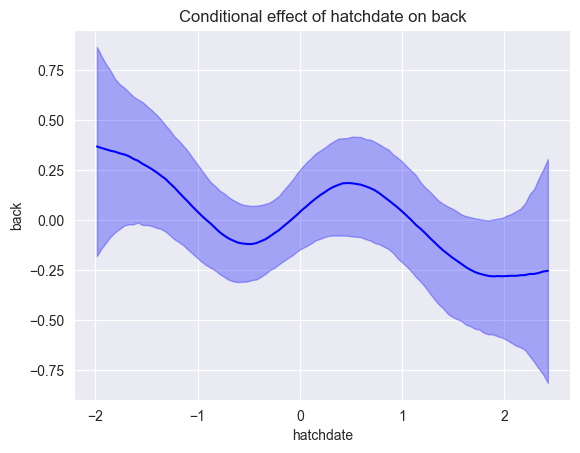

In [47]:
result = brms.call("conditional_effects", fit3, "hatchdate", resp="back")
df_result = result['back.back_hatchdate']

df_plot = df_result.sort_values("hatchdate")

fig, ax = plt.subplots()

ax.plot(
    df_plot["hatchdate"],
    df_plot["estimate__"],
    color="blue"
)

ax.fill_between(
    df_plot["hatchdate"],
    df_plot["lower__"],
    df_plot["upper__"],
    alpha=0.3,
    color="blue"
)

ax.set_xlabel("hatchdate")
ax.set_ylabel("back")
ax.set_title("Conditional effect of hatchdate on back")

plt.show()

reveals a non-linear relationship of hatchdate on the back color, which seems to change in waves over the course of the hatch dates.

There are many more modeling options for multivariate models, which are not discussed in this vignette. Examples include autocorrelation structures, Gaussian processes, or explicit non-linear predictors (e.g., see help("brmsformula") or vignette("brms_multilevel")). In fact, nearly all the flexibility of univariate models is retained in multivariate models.

## References

Hadfield JD, Nutall A, Osorio D, Owens IPF (2007). Testing the phenotypic gambit: phenotypic, genetic and environmental correlations of colour. Journal of Evolutionary Biology, 20(2), 549-557.